## Create graphs from neuron morphologies, then train a NN on classification

https://docs.dgl.ai/en/0.6.x/guide/training-graph.html

In [1]:
import dgl
from dgl.data import DGLDataset
from dgl.dataloading import GraphDataLoader
from dgl.data.utils import download, check_sha1
import dgl.nn.pytorch as dglnn
from dgl.nn.pytorch import GraphConv
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from pathlib import Path
import pandas as pd
import random
from sklearn.decomposition import PCA
import statistics
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm.auto import tqdm, trange

import os
from dgl.data.utils import download

from dgl import save_graphs, load_graphs
from dgl.data.utils import makedirs, save_info, load_info


import webscrape2 as ws

Using backend: pytorch


In [2]:
def get_morphology(file_name: str):
    with open(file_name, "rb") as f: #rb = read only, binary
        data = f.read().decode("utf-8")  #utf is a unicode standard

    data = data.split("\r\n") #rn is the "token"

    # making each item a list
    # split on the space
    # also removing all the comments at the beginning, the len line thing is to account for blank lines
    # the .strip is to get rid of blank spaces
    data_list = [line.strip().split(" ") for line in data if len(line)>0 and line[0]!='#']

    df = pd.DataFrame(data_list, columns=["sample", "structure", "x", "y", "z", "diameter", "parent"])
    df = df.set_index("sample").iloc[:-1] #index up until the last, omit last line cuz it's blank
    df = df.astype({"structure":int, "x":float, "y":float, "z":float, "diameter":float, "parent":int})
    df.index = df.index.astype(int) #1, 2, 3 not "1" etc

    #making this 2D not 3D
    pca = PCA(2)
    pca.fit_transform(df[["x", "y"]]) #2 brackets cuz inner makes the list, outer accesses the columns

    df[["PC1", "PC2"]] = pca.fit_transform(df[["x", "y"]])
    
    #now we know the very original parent for each sample (each sample is a circle)
    def funct(s): #s is the series
        parent = max(1, s["parent"]) #give us values unless it's less than 1
        return df.loc[parent]
    
    # now we have vectors between the samples, the x, y, x vals
    delta = df - df.apply(funct, axis=1)

    #writing this new length column into the original df
    df["length"] = np.sqrt(delta["PC1"]**2 + delta["PC2"]**2)
    df["theta"] = np.arctan(delta["PC1"]/delta["PC2"])

    # replacing the -1 parent value for the first sample with 0
    df[df < 0] = 0
    
    return df

In [3]:
def make_graph(df: pd.DataFrame):
    # source node array u and destination node array v
    u = np.array(df["parent"][1:]-1) #leave out the first row, make 1 index into 0
    v = np.array(df.index[1:]-1)

    g = dgl.graph((u, v))
    
    df = df.fillna(0)

    # making tensors of the vector lengths and angles
    #lengths = torch.Tensor(df["length"].tolist())
    #thetas = torch.Tensor(df["theta"].fillna(0).tolist()) # also making the first theta 0

    # assigning the length and angle features to the edges
    #g.ndata['lengths'] = lengths
    #g.ndata['thetas'] = thetas
    g.ndata['info'] = torch.Tensor(df[['length', 'theta']].values)
    # ^^ can add 3rd dimension with another theta value, maybe diameter
    
    return g, df["structure"].values - 1  # df["structure"] will be the label (soma, dendrite, etc.)
    print(u)

In [4]:
class MyDataset(DGLDataset):
    
    def __init__(self,
                 archive='',
                 url=None,
                 raw_dir=None,
                 save_dir=None,
                 force_reload=False,
                 verbose=False):  
        self.archive = archive
        self.files = []
        main_path = Path('/home/ellismith/swc_to_graph')
        if raw_dir is None:
            raw_dir = main_path / 'swc_files'
        if save_dir is None:
            save_dir = main_path / 'swc_graphs'
            
        super().__init__(name=archive,
                                        url=url,
                                        raw_dir=raw_dir,
                                        save_dir=save_dir,
                                        force_reload=force_reload,
                                        verbose=verbose)
        
    label_options = ['granule', 'mitral', 'short axon', 'pyramidal', 'tufted', 'basket']
    
    def has_cache(self):
        # check whether there are processed data in `self.save_path`
        pass

    def download(self):
        # path to store the file
        # make sure to use the same suffix as the original file name's
        url = self.url
        print("Downloading from %s" % self.url)
        
        result = ws.get_swc(self.archive, self.raw_dir)
    
    def process(self): 
        # process data to a list of graphs and a list of labels
        
        self.files = []
        self.raw_labels = []
        self.graphs = []
        
        files = list(self.raw_dir.iterdir())
        #files = files[:30]
        for file in tqdm(files):
            if file.is_file():
                self.files.append(file.name)
                label = None
                for kind in self.label_options:
                    if kind in file.name:
                        label = kind
                assert label, file.name
                self.raw_labels.append(label)   

                graph = None
                df = get_morphology(file)
                graph = make_graph(df)
                self.graphs.append(graph[0])
        
        # convert labels from words (cell types) to integer values 
        label_nums = [self.label_options.index(label) for label in self.raw_labels]
        self.labels = torch.tensor(label_nums)
        
        # top_2 is a list of the top 2 most frequent labels 
        self.top_2 = pd.Series(self.labels).value_counts().index[:2].to_list()
        
        # converts labels_list from tensor to list 
        self.labels_list = self.labels.tolist()
        
        # create a new list of graphs and tensor of labels from only the top 2 labels
        
        graphs_and_labels = zip(self.graphs, self.labels_list)
        filtered = [(graph, self.top_2.index(label)) for graph, label in graphs_and_labels if label in self.top_2]
        self.graphs_filtered, self.labels_filtered = zip(*filtered)
        self.labels_filtered = torch.tensor(self.labels_filtered)
        
        self.graphs_filtered = list(self.graphs_filtered)
        
    def __getitem__(self, idx): 
        # __getitem__(idx) should return tuple (graph, label)
        return self.graphs_filtered[idx], self.labels_filtered[idx]

    def __len__(self):
        # number of data examples
        return len(self.graphs_filtered)

    def save(self):
        # save graphs and labels
        graph_path = self.save_dir / 'dgl_graph.bin'
        save_graphs(str(graph_path), self.graphs_filtered, {'labels': self.labels_filtered})    
        
    def load(self):
        # load processed data from directory `self.save_path`
        graph_path = self.save_dir / 'dgl_graph.bin'
        self.graphs_filtered, label_dict = load_graphs(str(graph_path))
        self.labels_filtered = label_dict['labels']   
        
    def has_cache(self):
        # check whether there are processed data in `self.save_path`
        graph_path = self.save_dir / 'dgl_graph.bin'
        return graph_path.is_file()
        
    def del_cache(self):
        graph_path = self.save_dir / 'dgl_graph.bin'
        if graph_path.is_file():
            graph_path.unlink()

In [7]:
dataset.del_cache()

In [8]:
dataset = MyDataset()

  0%|          | 0/237 [00:00<?, ?it/s]

In [9]:
print(len(dataset.labels_filtered))
if len(dataset.labels_filtered) == len(dataset.graphs_filtered):
    print("yay!")

184
yay!


In [10]:
# create dataloaders
dataloader = GraphDataLoader(dataset, batch_size=10, drop_last=False, shuffle=True)

In [11]:
# change to one hidden dim, change the size of it

class Classifier(nn.Module):
    def __init__(self, n_features, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = dglnn.GraphConv(n_features, hidden_dim, allow_zero_in_degree=self.allow_zero_in_degree)
        self.conv2 = dglnn.GraphConv(hidden_dim, hidden_dim, allow_zero_in_degree=self.allow_zero_in_degree)
        self.classify = nn.Linear(hidden_dim, n_classes)
        
    allow_zero_in_degree=True

    def forward(self, g, info):
        # Apply graph convolution and activation.
        # activation options: F.relu, torch.sigmoid, torch.tanh
        info = torch.tanh(self.conv1(g, info))
        info = torch.tanh(self.conv2(g, info))
        # info = torch.cat(info, something)  if I want to include global/morphometric feature info
        with g.local_scope():
            g.ndata['info'] = info
            # Calculate graph representation by average readout.
            hg = dgl.mean_nodes(g, 'info')
            return self.classify(hg)

In [112]:
#torch.randperm(num_examples)

In [50]:
"""
model = Classifier(2, 5, 5, 6)
opt = torch.optim.Adam(model.parameters())
for epoch in range(50):
    for batched_graph, labels in dataloader:
        feats = batched_graph.ndata['info']
        logits = model(batched_graph, feats)
        loss = F.cross_entropy(logits, labels)
        opt.zero_grad()
        loss.backward()
        opt.step()
"""

"\nmodel = Classifier(2, 5, 5, 6)\nopt = torch.optim.Adam(model.parameters())\nfor epoch in range(50):\n    for batched_graph, labels in dataloader:\n        feats = batched_graph.ndata['info']\n        logits = model(batched_graph, feats)\n        loss = F.cross_entropy(logits, labels)\n        opt.zero_grad()\n        loss.backward()\n        opt.step()\n"

In [12]:
torch.manual_seed(0)  #this one is setting the random seed for torch.randperm
random.seed(0)
np.random.seed(0)
# deterministically goes through the same set of random numbers
# every time this seed gets re-run, back to the same initial set of random values

In [13]:
num_examples = len(dataset)
num_train = int(num_examples * 0.8)

random_list = torch.randperm(num_examples)  #this is shuffling the values
train_sampler = SubsetRandomSampler(random_list[:num_train])
test_sampler = SubsetRandomSampler(random_list[num_train:])

train_dataloader = GraphDataLoader(dataset, sampler=train_sampler, batch_size=10, drop_last=False)
test_dataloader = GraphDataLoader(dataset, sampler=test_sampler, batch_size=10, drop_last=False)

# the GraphDataLoader will return two objects for each iteration
# first element is batched graph
# second element is label vector representing category of each graph in the mini-batch

In [14]:
random_list

tensor([180, 148, 107,  36,  47,  29,  77, 113,   7,  42, 105,  55,  96, 115,
         22,  15, 160, 127,  76, 172,  74, 161,  57,  95,  48,  75,  10, 149,
        109, 124, 129, 121,  99,  68, 179,  39, 102, 165, 119,  67,   9, 128,
        122, 182, 155,  79, 131,  59,  78,  44,  60, 139,  93, 181,  65,  12,
         87,  86,  50, 136,  17,  41, 175,  66,  38, 135, 152,  64,  88, 146,
         52,  24,  94,  83,  43,  84,  45,  61, 103,  25, 178, 132, 162, 159,
        153, 177, 101, 174,  49,  82,  34,   6, 126, 145,  27,  58,  56, 104,
         46, 111, 117,  62,  69, 169, 108,  85,  80, 112,  54, 100,  90, 154,
          0,  63, 158,  14,  35, 176,  98, 114, 143, 167,  33,  89, 137,   2,
         71, 140,  26, 130,  28, 116,  91,  40, 168,   5, 138, 183, 166, 120,
        157,  73,  32, 125,  37,  21,  97,   4, 173, 118, 142,  20, 170, 156,
        134,   3,  31, 171, 106, 151,   8,  81,  13, 133, 163,  30,  72,  19,
         23, 110,  92, 150, 164, 141, 123, 147,  70,  18,   1,  

In [136]:
list = [1, 2, 3, 4, 5]
df = pd.DataFrame(columns=range(3))
df['seed'] = list
df

,0,1,2,seed
0,NaN,NaN,NaN,1
1,NaN,NaN,NaN,2
2,NaN,NaN,NaN,3
3,NaN,NaN,NaN,4
4,NaN,NaN,NaN,5


In [139]:
size_hidden_dim = list(range(1, 10))

TypeError: 'list' object is not callable

In [29]:
size_hidden_dim = list(range(1, 10))
#accuracy = pd.DataFrame(index=size_hidden_dim)
accuracy = pd.DataFrame(index=size_hidden_dim, columns=range(5))
test_loss_epoch50 = pd.DataFrame(index=size_hidden_dim, columns=range(5))
mean_test_loss = []
sd_test_loss = []

for i in size_hidden_dim:
    # run over 5 different random seeds
    for seed in range(5):
        torch.manual_seed(seed)
        model = Classifier(2, i, 2)
        opt = torch.optim.Adam(model.parameters(), lr=0.001)
        train_loss_list=[]
        test_loss_list = []
        for epoch in range(100):
            train_loss_list_epoch = []
            test_loss_list_epoch = []
            for batched_graph, labels in train_dataloader:
                feats = batched_graph.ndata['info']
                logits = model(batched_graph, feats)  # logits is non-normalized prob value

                train_loss = F.cross_entropy(logits, labels)  # cross entropy is a measure of agreement between label and prediction probability
                train_loss_list_epoch.append(train_loss.tolist())
                opt.zero_grad()
                train_loss.backward()
                opt.step()
            mean_train_loss_epoch = statistics.mean(train_loss_list_epoch)
            train_loss_list.append(mean_train_loss_epoch)

            for batched_graph, labels in test_dataloader:
                feats = batched_graph.ndata['info']
                logits = model(batched_graph, feats)
                #print(labels)
                test_loss = F.cross_entropy(logits, labels)
                test_loss_list_epoch.append(test_loss.tolist())
            mean_test_loss_epoch = statistics.mean(test_loss_list_epoch)
            test_loss_list.append(mean_test_loss_epoch)
        mean_test_loss.append(statistics.mean(test_loss_list))
        sd_test_loss.append(statistics.stdev(test_loss_list))  
            
        #test_loss_epoch50.loc[i, seed] = test_loss_list[50]

        num_correct = 0
        num_tests = 0
        for batched_graph, labels in test_dataloader:
            pred = model(batched_graph, batched_graph.ndata['info'].float())
            num_correct += (pred.argmax(1) == labels).sum().item()
            num_tests += len(labels)
        test_accuracy = num_correct / num_tests
        print('hidden layer 1 size:',i, 'Test accuracy:', test_accuracy)
        #accuracy.loc[i, seed] = test_accuracy[50]
        #accuracy_list[]
        
  # want mean and SD loss and accuracy for each row (over all random seeds)      


hidden layer 1 size: 1 Test accuracy: 0.7297297297297297
hidden layer 1 size: 1 Test accuracy: 0.7297297297297297
hidden layer 1 size: 1 Test accuracy: 0.6486486486486487
hidden layer 1 size: 1 Test accuracy: 0.6486486486486487
hidden layer 1 size: 1 Test accuracy: 0.6486486486486487
hidden layer 1 size: 2 Test accuracy: 0.7297297297297297
hidden layer 1 size: 2 Test accuracy: 0.7297297297297297
hidden layer 1 size: 2 Test accuracy: 0.7297297297297297
hidden layer 1 size: 2 Test accuracy: 0.7297297297297297
hidden layer 1 size: 2 Test accuracy: 0.7297297297297297
hidden layer 1 size: 3 Test accuracy: 0.7297297297297297
hidden layer 1 size: 3 Test accuracy: 0.7297297297297297
hidden layer 1 size: 3 Test accuracy: 0.7297297297297297
hidden layer 1 size: 3 Test accuracy: 0.7297297297297297
hidden layer 1 size: 3 Test accuracy: 0.7297297297297297
hidden layer 1 size: 4 Test accuracy: 0.7297297297297297
hidden layer 1 size: 4 Test accuracy: 0.7297297297297297
hidden layer 1 size: 4 Test acc

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [60]:
test_loss_epoch50

[0.645282194018364,
 0.41598760336637497,
 0.41448522359132767,
 0.3521746024489403,
 0.3460733965039253,
 0.4190138205885887,
 0.4137316420674324,
 0.4276607520878315,
 0.3469378091394901,
 0.3512844443321228,
 0.42202650010585785,
 0.357352327555418,
 0.427444726228714,
 0.3829192891716957,
 0.3336193710565567,
 0.36268263682723045,
 0.34306010231375694,
 0.3465927727520466,
 0.4183403328061104,
 0.406993143260479,
 0.40233977511525154]

ValueError: x and y must be the same size

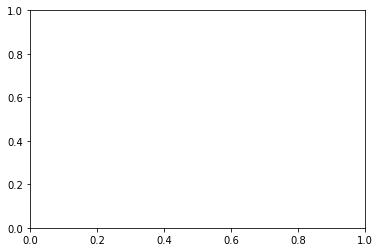

In [32]:
plt.scatter(size_hidden_dim, test_loss_epoch50)
plt.xlabel('# of nodes in hidden layer 1')
plt.ylabel('test loss after 50 epochs')
plt.xticks(np.arange(min(size_hidden_dim), max(size_hidden_dim)+1, 1.0))
plt.title("i: size of hidden layer 1, (2, i, 5, 2), learning rate = 0.001, tanh activation functions")
plt.show()

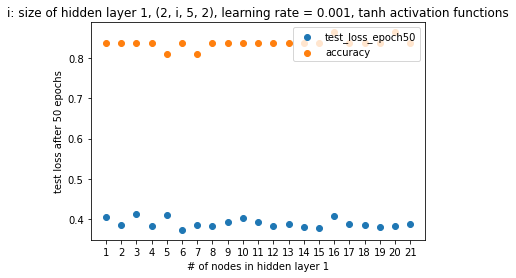

In [78]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(size_hidden_dim1, test_loss_epoch50, label='test_loss_epoch50')
ax.scatter(size_hidden_dim1, accuracy_list, label='accuracy')
plt.legend(loc='upper right');
plt.xlabel('# of nodes in hidden layer 1')
plt.ylabel('test loss after 50 epochs')
plt.xticks(np.arange(min(size_hidden_dim1), max(size_hidden_dim1)+1, 1.0))
plt.title("i: size of hidden layer 1, (2, i, 5, 2), learning rate = 0.001, tanh activation functions")
plt.show()

In [17]:
model = Classifier(2, 5, 5, 2)
opt = torch.optim.Adam(model.parameters())
train_loss_list=[]
test_loss_list = []
for epoch in range(100):
    train_loss_list_epoch = []
    test_loss_list_epoch = []
    for batched_graph, labels in train_dataloader:
        feats = batched_graph.ndata['info']
        logits = model(batched_graph, feats)  # logits is non-normalized prob value
        train_loss = F.cross_entropy(logits, labels)  # cross entropy is a measure of agreement between label and prediction probability
        train_loss_list_epoch.append(train_loss.tolist())
        opt.zero_grad()
        train_loss.backward()
        opt.step()
    mean_train_loss = statistics.mean(train_loss_list_epoch)
    train_loss_list.append(mean_train_loss)
    
    for batched_graph, labels in test_dataloader:
        feats = batched_graph.ndata['info']
        logits = model(batched_graph, feats)
        test_loss = F.cross_entropy(logits, labels)
        test_loss_list_epoch.append(test_loss.tolist())
    mean_test_loss = statistics.mean(test_loss_list_epoch)
    test_loss_list.append(mean_test_loss)

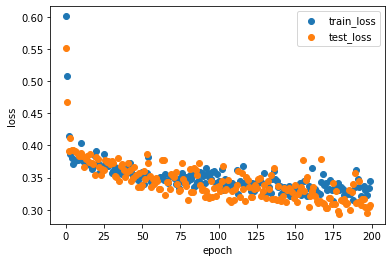

In [68]:
fig = plt.figure()
ax = fig.add_subplot(111)

epoch_train = list(range(len(train_loss_list)))
epoch_test = list(range(len(test_loss_list)))

ax.scatter(epoch_train, train_loss_list, label='train_loss')
ax.scatter(epoch_test, test_loss_list, label='test_loss')

plt.legend(loc='upper right');
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()